In this notebook we fetch one week of Swarm data from VirES and perform a basic spherical harmonic analysis to retrieve a main field model.

We use [`design_gauss()`](https://github.com/ancklo/ChaosMagPy/blob/6c1077f901d7827a355da366a4df952f7e602681/chaosmagpy/model_utils.py#L496) from [`chaosmagpy`](https://github.com/ancklo/ChaosMagPy) v0.1 (Clemens Kloss)

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from viresclient import SwarmRequest
import chaosmagpy as cp

# Fetch filtered data as an xarray Dataset

... explain subsampling and data selection ("filters") ...

In [2]:
request = SwarmRequest()

request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    sampling_step="PT10S"
)
request.set_range_filter('Kp', 0, 3)

ds = request.get_between(
    start_time=dt.datetime(2019,2,1),
    end_time=dt.datetime(2019,2,8)
).as_xarray()
ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (2.966MB)


<xarray.Dataset>
Dimensions:     (Timestamp: 51839, dim: 3)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2019-02-01T00:00:10 ... 2019-02-07T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft  (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Latitude    (Timestamp) float64 45.32 45.96 46.61 47.25 ... 34.4 35.04 35.69
    Longitude   (Timestamp) float64 -174.4 -174.4 -174.4 ... 175.4 175.4 175.4
    Radius      (Timestamp) float64 6.809e+06 6.808e+06 ... 6.81e+06 6.81e+06
    B_NEC       (Timestamp, dim) float64 1.913e+04 2.076e+03 ... 2.532e+04
Attributes:
    Sources:         ['SW_OPER_AUX_KP__2__19980101T013000_20190824T073000_000...
    MagneticModels:  []
    RangeFilters:    ['Kp:0,3']

# Inspect data plots... (tbc)

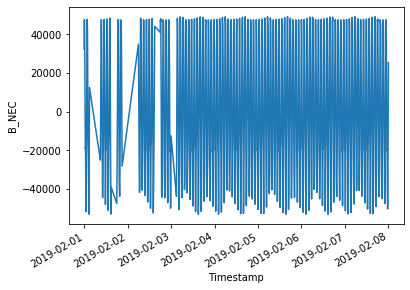

In [4]:
ds["B_NEC"][:, 2].plot();

# Converting between B_NEC and (B$_r$, B$_\theta$, B$_\phi$)

B_NEC contains components (North, East, Centre), i.e. pointing Northwards, Eastwards, and radially downwards.

B$_r$ points radially upwards. B$_\theta$ points in the direction of increasing colatitude ($\theta$), i.e. Southwards. B$_\phi$ points in the direction of increasing longitude ($\phi$), i.e. Eastward.

So B$_r$, B$_\theta$, B$_\phi$ = `-ds["B_NEC"][:, 2]`, `-ds["B_NEC"][:, 0]`, `ds["B_NEC"][:, 1]`

In [5]:
B_radius, B_theta, B_phi = -ds["B_NEC"][:, 2], -ds["B_NEC"][:, 0], ds["B_NEC"][:, 1]

# Build Gauss design matrix

In [6]:
nmax = 13

A_radius, A_theta, A_phi = cp.model_utils.design_gauss(
    ds["Radius"]/1e3,  # Input must be in km
    90-ds["Latitude"], # as colatitude
    ds["Longitude"],
    nmax
)

In [7]:
G = np.vstack((A_radius, A_theta, A_phi))
G.shape

(155517, 195)

In [8]:
d = np.hstack((B_radius, B_theta, B_phi))
d.shape

(155517,)

# Least squares inversion

We want to solve for $m$:
$$
\begin{align}
 d     &= G m \\
 G^T d &= G^T G m \\
 m     &= (G^T G)^{-1} G^T d
\end{align}
$$

In [9]:
gauss_coeffs = np.linalg.inv(G.T @ G) @ (G.T @ d)

alternatively:

In [10]:
gauss_coeffs = np.linalg.lstsq(G, d, rcond=None)[0]

# Power spectrum

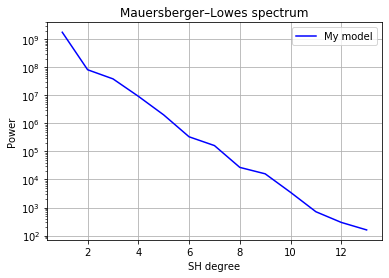

In [11]:
power_spec = cp.model_utils.power_spectrum(gauss_coeffs)
fig, ax = plt.subplots(1, 1)
ax.semilogy(np.arange(1,14), power_spec, 'b-', label="My model")
ax.set_xlabel("SH degree")
ax.set_ylabel("Power")
ax.set_title("Mauersberger–Lowes spectrum")
ax.legend()
ax.grid();

# Next: evaluation and plotting components, ... ?